In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statannot import add_stat_annotation

from utils import quick_load_liuzhong_health_check_data, parse_dict_with_default
from plot_utils import Stack, Scatter, Sankey, BxxPvalue

%matplotlib inline
%load_ext autoreload
%autoreload 2

import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
import rpy2.robjects.lib.ggplot2 as ggplot2
%load_ext rpy2.ipython

warnings.filterwarnings("ignore")

df_table1plus, l_consecute_man2p, l_consecute_man3p, df_table1plus_3p_revMM, df_meta_group, rename_dict = quick_load_liuzhong_health_check_data()
workdir = "/cluster/home/bqhu_jh/projects/healthman/analysis/liuzhong/human/clinical/figures"

Welcome to BMBDC, happy coding.


In [2]:
%%R
pkgs <- c("fs", "configr", "stringr", "jhtools", "glue", "tidyverse", "dplyr", 
          "readr", "jhdata", "ggplot2", "ggpubr", "patchwork")
for (pkg in pkgs){
  suppressPackageStartupMessages(library(pkg, character.only = T))
}



project <- "healthman"
species <- "human"
dataset <- "liuzhong"

workdir <- glue("~/projects/{project}/analysis/")
setwd(workdir)

## People number

In [3]:
df_table1plus[["period", "gender"]].\
            pivot_table(index="period", values="gender", aggfunc=len).\
            reset_index()

variable,period,gender
0,Control-2021,88920
1,Control-2022,90751
2,Test-2023,56010


In [4]:
# left, year number
p1_df = df_table1plus[["period", "gender"]].\
            pivot_table(index="period", values="gender", aggfunc=len).\
            reset_index()

# middle, year-gender number
p2_df_a = df_table1plus[["period", "gender"]].\
            pivot_table(index=["period", "gender"], aggfunc=len).\
            reset_index()
p2_df_a.columns = ["period", "gender", "number"]
p2_df_c = df_table1plus_3p_revMM[["period", "gender", "sample_id"]].\
            pivot_table(index=["period", "gender"], values="sample_id", aggfunc=lambda x: len(set(x))).\
            reset_index()
p2_df_c.columns = ["period", "gender", "number"]
p2_df_c = p2_df_c.iloc[0:2]
p2_df_c["period"] = "3 periods"

p2_df = pd.concat([p2_df_a, p2_df_c])

col_used = ["period", "gender", "age"]

p3_age_df = df_table1plus[col_used]
p3_age_df

p4_age_df = df_table1plus_3p_revMM[col_used]
p4_age_df

variable,period,gender,age
61301,Control-2021,female,28
61305,Control-2022,female,29
61309,Test-2023,female,30
68071,Control-2021,female,24
68076,Control-2022,female,25
...,...,...,...
20585,Control-2022,male,52
20587,Test-2023,male,53
24871,Control-2021,male,48
24873,Control-2022,male,49


In [5]:
print(p3_age_df["age"].mean())
print(p3_age_df.groupby([ "gender"]).agg(np.nanmean))
p3_age_df.groupby(["period", "gender"]).agg(np.nanmean)

42.92667631247322
variable        age
gender             
female    41.345585
male      44.460961


variable                   age
period       gender           
Control-2021 female  41.017203
             male    44.196184
Control-2022 female  41.306664
             male    44.358351
Test-2023    female  41.927535
             male    45.051089

In [6]:
print(p4_age_df["age"].mean())
print(p4_age_df[p4_age_df["period"]=="Test-2023"]["age"].mean())
print(p4_age_df.groupby([ "gender"]).agg(np.nanmean))
p4_age_df.groupby(["period", "gender"]).agg(np.nanmean)

44.26477333109601
45.26478731437201
variable        age
gender             
female    42.177609
male      46.658321


variable                   age
period       gender           
Control-2021 female  41.177321
             male    45.657331
Control-2022 female  42.178027
             male    46.659132
Test-2023    female  43.177478
             male    47.658501

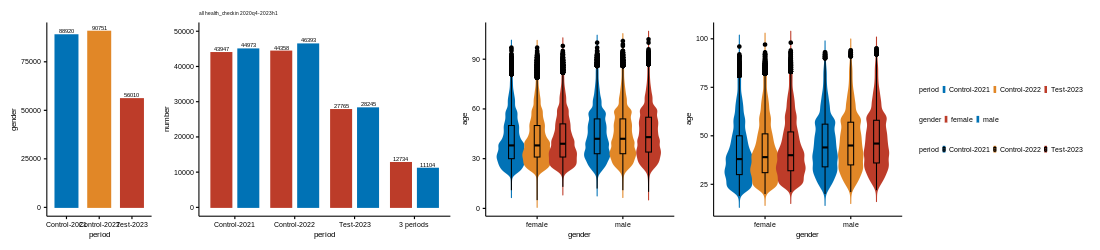

In [7]:
%%R -i p1_df -i p2_df -i p3_age_df -i p4_age_df -w 1100 -h 250 -u px

cols_gender <- ggsci::pal_nejm("default")(2)
colrs_year <- c("Control-2021" = "#0172B6",  "Control-2022" = "#E18727", "Test-2023" = "#BD3C29")
p1_df$period <- factor(p1_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p2_df$period <- factor(p2_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023", "3 periods"))
p3_age_df$period <- factor(p3_age_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p4_age_df$period <- factor(p4_age_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))

p2_df$gender <- factor(p2_df$gender, levels=c("female",  "male"))
p3_age_df$gender <- factor(p3_age_df$gender, levels=c("female",  "male"))
p4_age_df$gender <- factor(p4_age_df$gender, levels=c("female",  "male"))


p1 <- ggbarplot(p1_df, "period", "gender",
                fill = "period",  color = "period",
                palette = colrs_year, label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
          axis.title.y = element_text(size = 8),
          axis.text.y = element_text(size = 7),
          axis.title.x = element_text(size = 8),
          axis.text.x = element_text(size = 7),
          legend.text = element_text(size = 7),
          legend.title = element_text(size = 7),
          legend.key.size = unit(0.1, 'cm'))

p2 <- ggbarplot(p2_df, "period", "number",
                fill = "gender",  color = "gender",
                palette = cols_gender, label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    ylim(0, 50000) +
    ggtitle("all health_check in 2020q4-2023h1") +
    theme(title = element_text(size = 4),
          axis.title.y = element_text(size = 8),
          axis.text.y = element_text(size = 7),
          axis.title.x = element_text(size = 8),
          axis.text.x = element_text(size = 7),
          legend.text = element_text(size = 7),
          legend.title = element_text(size = 7),
          legend.key.size = unit(0.1, 'cm'))

p3 <- ggviolin(p3_age_df, "gender", "age",
                fill = "period", 
                color = "period",
                palette = colrs_year,
                add = "boxplot", 
                add.params = list(color="black"),
                position = position_dodge(0.9)
    ) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm'))

p4 <- ggviolin(p4_age_df, "gender", "age",
                fill = "period", 
                color = "period",
                palette = colrs_year,
                add = "boxplot", 
                add.params = list(color="black"),
                position = position_dodge(0.9)
    ) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm'))

pc <- (p1|p2|p3|p4) +
  plot_layout(guides = 'collect', widths = c(0.5, 1.2, 0.9, 0.9))
ggsave(glue("~/projects/{project}/analysis/liuzhong/{species}/clinical/figures/Figure1_ABC.pdf"), pc, 
           width = 11, height = 2.5)
pc

## people number by month

In [8]:
col_used = ["period", "month", "gender", "sample_id"]
# p1
p1_df = df_table1plus[col_used].\
    pivot_table(index=col_used[:-1], values="sample_id", aggfunc=lambda x: len(set(x))).\
    reset_index()
p1_df.columns = col_used[:-1] + ["number"]


df_common_2p = df_table1plus[df_table1plus["sample_id"].isin(l_consecute_man2p)]
df_common = df_table1plus[df_table1plus["sample_id"].isin(l_consecute_man3p)]

# p2
p2_p2_df = df_common_2p[col_used].\
    pivot_table(index=col_used[:-1], values="sample_id", aggfunc=lambda x: len(set(x))).\
    reset_index()
p2_p2_df.columns = col_used[:-1] + ["number"]
p2_p3_df = df_common[col_used].\
    pivot_table(index=col_used[:-1], values="sample_id", aggfunc=lambda x: len(set(x))).\
    reset_index()
p2_p3_df.columns = col_used[:-1] + ["number"]

# p3
p3_age_df = df_table1plus[col_used+["age"]].\
    pivot_table(index=col_used[:-1], values="age", aggfunc=np.nanmean).\
    reset_index()

# p4
p4_p2age_df = df_common_2p[col_used+["age"]].\
    pivot_table(index=col_used[:-1], values="age", aggfunc=np.nanmean).\
    reset_index()
p4_p3age_df = df_common[col_used+["age"]].\
    pivot_table(index=col_used[:-1], values="age", aggfunc=np.nanmean).\
    reset_index()

p2_p2_df = p2_p2_df[p2_p2_df["month"].isin([11,12,1,2,3, 4,5,6])]
p4_p2age_df = p4_p2age_df[p4_p2age_df["month"].isin([11,12,1,2,3, 4,5,6])]
p2_p3_df = p2_p3_df[p2_p3_df["month"].isin([11,12,1,2,3, 4,5,6])]
p4_p3age_df = p4_p3age_df[p4_p3age_df["month"].isin([11,12,1,2,3, 4,5,6])]

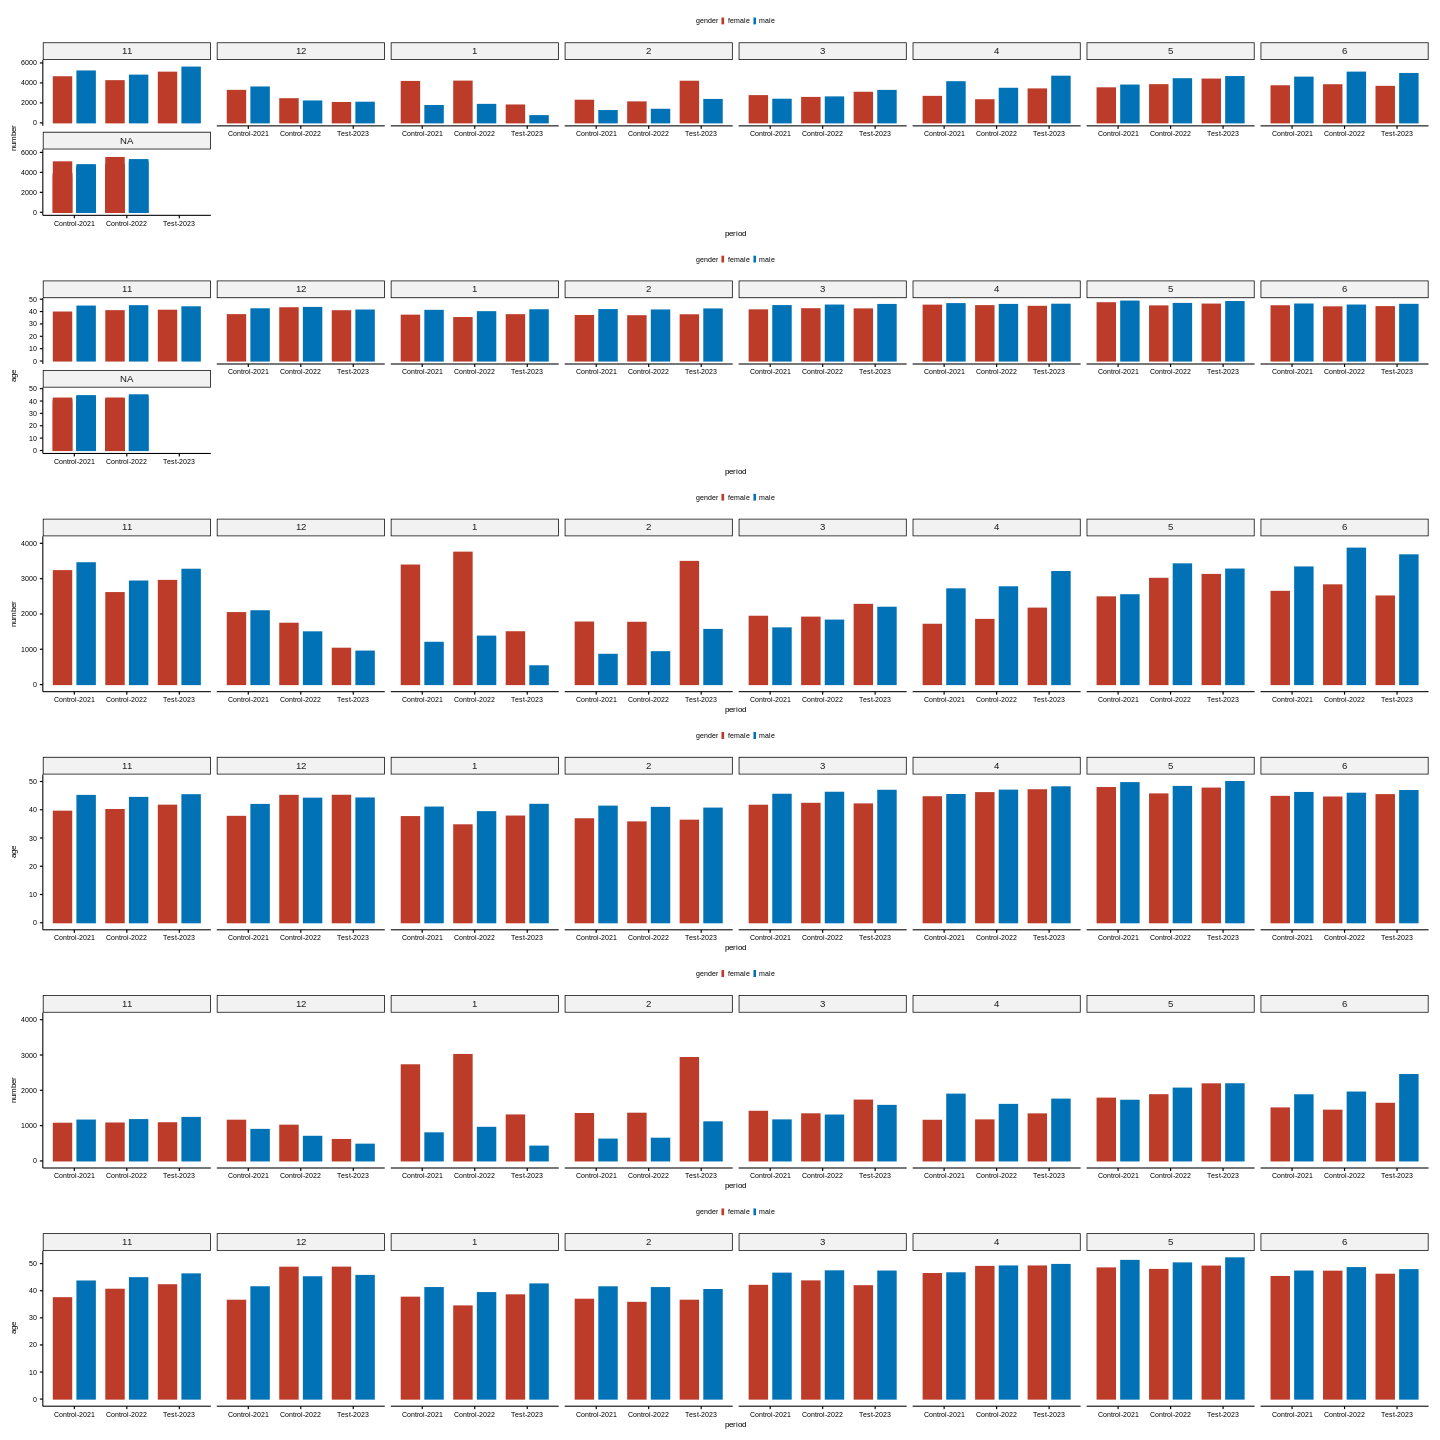

In [9]:
%%R -i p1_df -i p2_p2_df -i p2_p3_df -i p3_age_df -i p4_p3age_df -i p4_p2age_df -w 1440 -h 1440 -u px

cols_gender <- ggsci::pal_nejm("default")(2)
# colrs_year <- c("2021" = "#00AFBB",  "2022" = "#E7B800", "2023" = "#FF0000")
colrs_year <- c("Control-2021" = "#00AFBB",  "Control-2022" = "#E7B800", "Test-2023" = "#FF0000")


p2_p2_df$gender <- factor(p2_p2_df$gender, levels=c("female",  "male"))
p4_p3age_df$gender <- factor(p4_p3age_df$gender, levels=c("female",  "male"))
p4_p2age_df$gender <- factor(p4_p2age_df$gender, levels=c("female",  "male"))


p1_df$period <- factor(p1_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p2_p3_df$period <- factor(p2_p3_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p3_age_df$period <- factor(p3_age_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p4_p3age_df$period <- factor(p4_p3age_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p2_p2_df$period <- factor(p2_p2_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p4_p2age_df$period <- factor(p4_p2age_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))

p1_df$month <- factor(p1_df$month, levels=c(11,12, 1,2,3,4, 5,6))
p2_p3_df$month <- factor(p2_p3_df$month, levels=c(11,12,1,2,3,4,5,6))
p3_age_df$month <- factor(p3_age_df$month, levels=c(11,12, 1,2,3,4, 5,6))
p4_p3age_df$month <- factor(p4_p3age_df$month, levels=c(11,12,1,2,3,4,5,6))
p2_p2_df$month <- factor(p2_p2_df$month, levels=c(11,12,1,2,3,4,5,6))
p4_p2age_df$month <- factor(p4_p2age_df$month, levels=c(11,12,1,2,3,4,5,6))

p3 <- ggbarplot(p1_df, "period", "number",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm')) +
    ylim(0, 6000)

p31 <- ggbarplot(p2_p3_df, "period", "number",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm')) +
    ylim(0, 4000)
p31_p2 <- ggbarplot(p2_p2_df, "period", "number",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm')) +
    ylim(0, 4000)

p32 <- ggbarplot(p3_age_df, "period", "age",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm'))


p33 <- ggbarplot(p4_p3age_df, "period", "age",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm'))
p33_p2 <- ggbarplot(p4_p2age_df, "period", "age",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm'))

# merge
pc <- facet(p3, facet.by = "month", ncol=8) /
    facet(p32, facet.by = "month", ncol=8) /
    facet(p31_p2, facet.by = "month", ncol=8) /
    facet(p33_p2, facet.by = "month", ncol=8) /
    facet(p31, facet.by = "month", ncol=8) /
    facet(p33, facet.by = "month", ncol=8) 

ggsave(glue("~/projects/{project}/analysis/liuzhong/{species}/clinical/figures/FigureS1_A.pdf"), pc, 
           width = 13, height = 10)
pc

## correlation for features

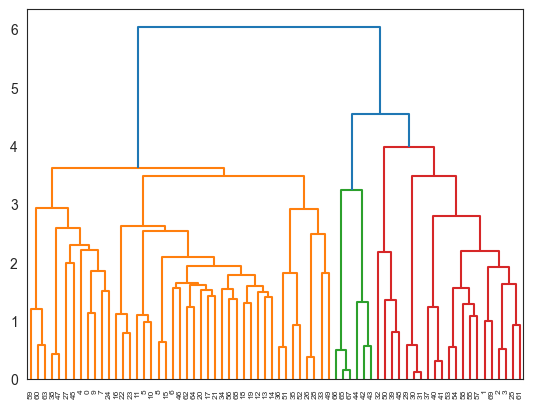

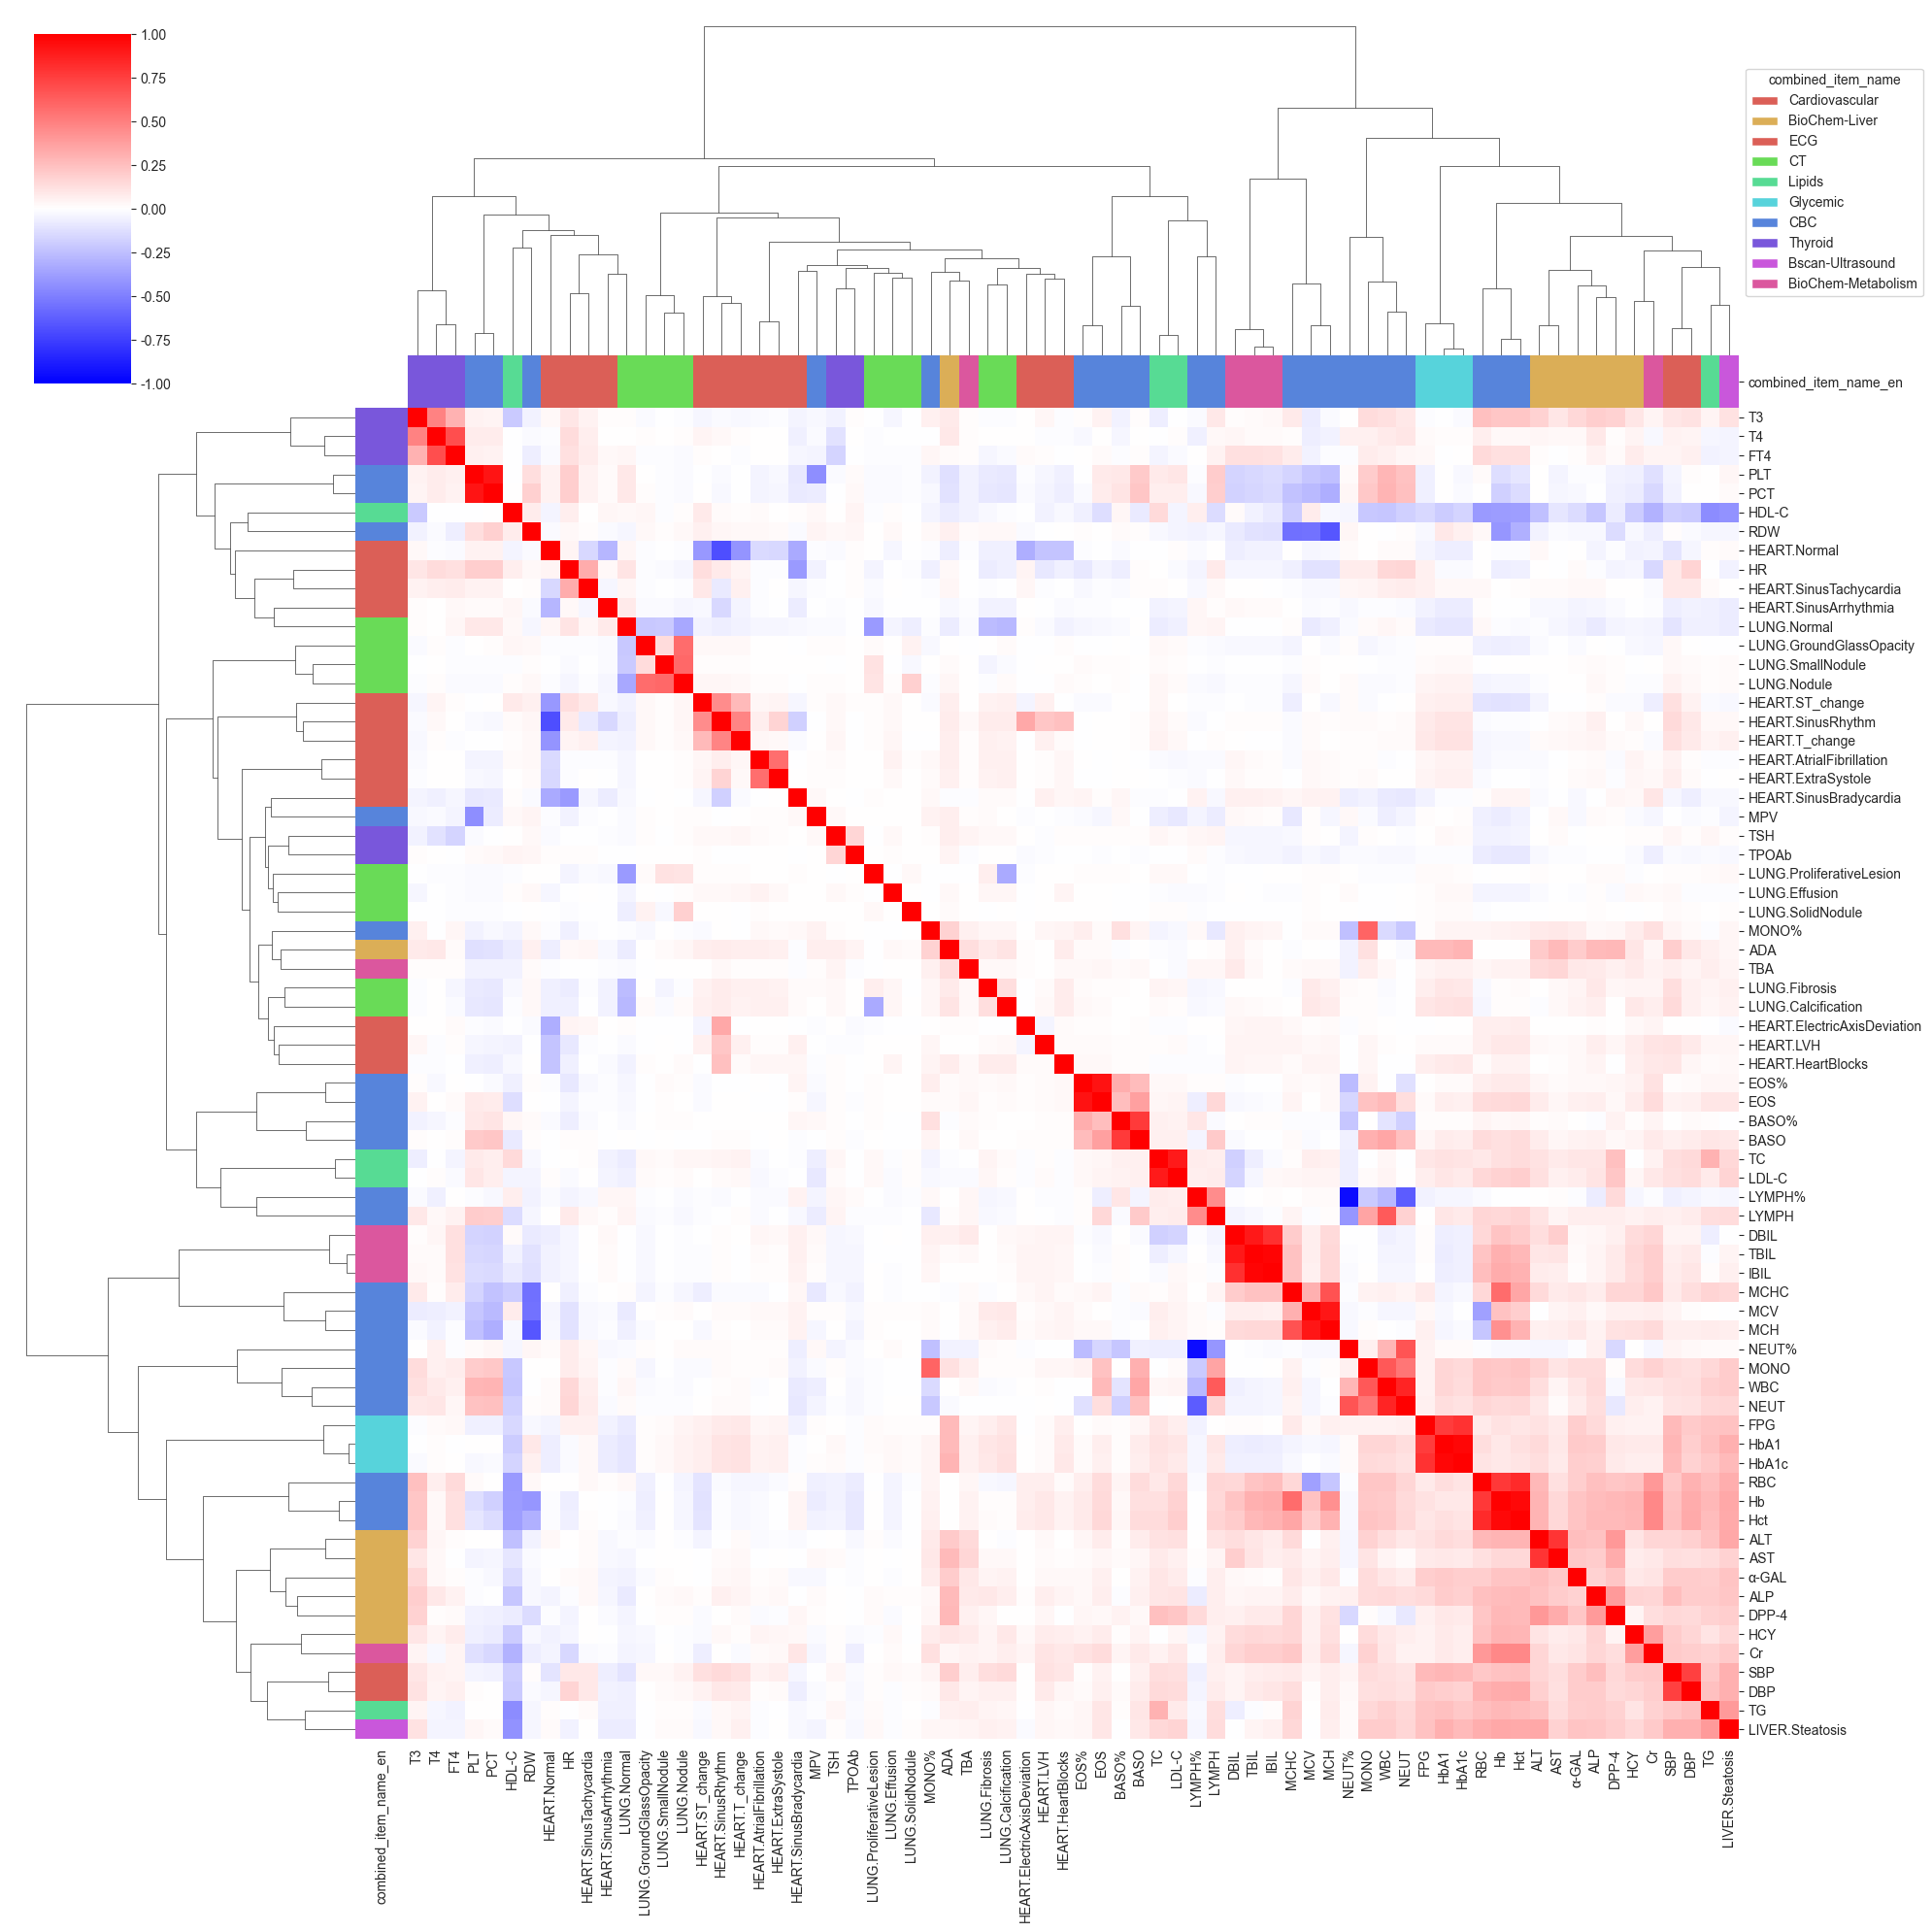

In [10]:
from matplotlib.patches import Patch

df_table1plus_allmonths = pd.read_parquet(f"/cluster/home/bqhu_jh/projects/healthman/analysis/tableOnePlusData-final_allmonths.parquet")
df_meta_groups = df_meta_group
l_high_lighted = list(df_meta_group["item_id"])
ss = sns.color_palette("hls", len(df_meta_groups["combined_item_name_en"].unique()))
lut = dict(zip(df_meta_groups["combined_item_name_en"].unique(), ss.as_hex()))
lut['Cardiovascular']   = '#db5f57'
lut['ECG']   = '#db5f57'

row_colors = df_meta_groups["combined_item_name_en"].map(lut)
row_colors.index = df_meta_groups["item_name_en"]


df_mat = df_table1plus_allmonths[l_high_lighted]
l_high_lighted_names = list(df_meta_groups["item_name_en"])
df_mat.columns = l_high_lighted_names
df_corr = df_mat.corr(method="pearson").fillna(0)
hclust = scipy.cluster.hierarchy.linkage(df_corr.fillna(0), method='ward', metric='euclidean', optimal_ordering=False)
dn = scipy.cluster.hierarchy.dendrogram(hclust)
fig = sns.clustermap(df_corr.fillna(0), cmap="bwr", vmin=-1, vmax=1, method="ward", row_linkage=hclust,
                        row_colors=row_colors, col_colors=row_colors,figsize=(20,20))

fig.ax_heatmap.set_title("")

handles = [Patch(facecolor=lut[name]) for name in lut]
fig.ax_col_dendrogram.legend(handles, lut, title='combined_item_name',
           bbox_to_anchor=(1, 0.5),  loc='center left')
fig.savefig(f"{workdir}/Figure1_F.pdf") 

In [11]:
df_mat = df_table1plus_allmonths[l_high_lighted]
l_high_lighted_names = [ parse_dict_with_default(x, default_dict=rename_dict) for x in l_high_lighted ]
df_mat.columns = l_high_lighted_names

df_mat1 = (~pd.isna(df_mat))
df_mat1["year-month"] = df_table1plus_allmonths.apply(lambda x: "%04d-%02d" % (x["year"],x["month"]), axis=1)

df_cnt_melt = pd.melt(
            df_mat1, id_vars=["year-month"]
        )

group_dict = {k:v for k,v in zip(df_meta_groups["item_name_en"], df_meta_groups["combined_item_name_en"])}
df_cnt_melt["group_name"] = [ parse_dict_with_default(x, group_dict) for x in list(df_cnt_melt["variable"]) ]

df_cnt = df_cnt_melt.pivot_table(
            index=["variable", "group_name"], columns="year-month", aggfunc=sum, values="value"
        ).loc[l_high_lighted_names]

df_cnt

,year-month,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,...,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06
variable,group_name,,,,,,,,,,,,,,,,,,,,,
HR,Cardiovascular,8682,6086,5309,3233,4621,6307,6746,7600,7010,7836,...,10051,9098,9684,3520,2302,5772,5819,7712,8518,8123
HCY,BioChem-Liver,5528,2702,4674,2839,3476,3230,4383,4079,1742,2980,...,5402,5611,5395,1204,212,915,2660,4599,5491,4144
SBP,Cardiovascular,8682,6086,5309,3233,4621,6307,6746,7600,7010,7837,...,10051,9098,9684,3521,2302,5770,5818,7712,8517,8123
DBP,Cardiovascular,8682,6086,5309,3233,4621,6307,6746,7600,7010,7837,...,10051,9098,9684,3521,2302,5772,5819,7712,8518,8123
HEART.Normal,ECG,7087,4753,4898,2745,3743,5035,5761,6725,6011,6416,...,8034,7373,7683,3284,2150,5125,4611,5922,7034,6567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBIL,BioChem-Metabolism,9109,6700,5817,3447,5040,6711,7220,8187,7832,8041,...,10635,9634,10361,4053,2482,6457,6249,8012,8952,8540
DBIL,BioChem-Metabolism,9109,6700,5816,3447,5040,6711,7220,8187,7832,8041,...,10635,9635,10361,4053,2482,6457,6249,8012,8952,8540
IBIL,BioChem-Metabolism,9109,6700,5815,3445,5039,6711,7220,8187,7832,8041,...,10622,9631,10353,4053,2482,6455,6247,7428,8904,8432


## Number of features availuable

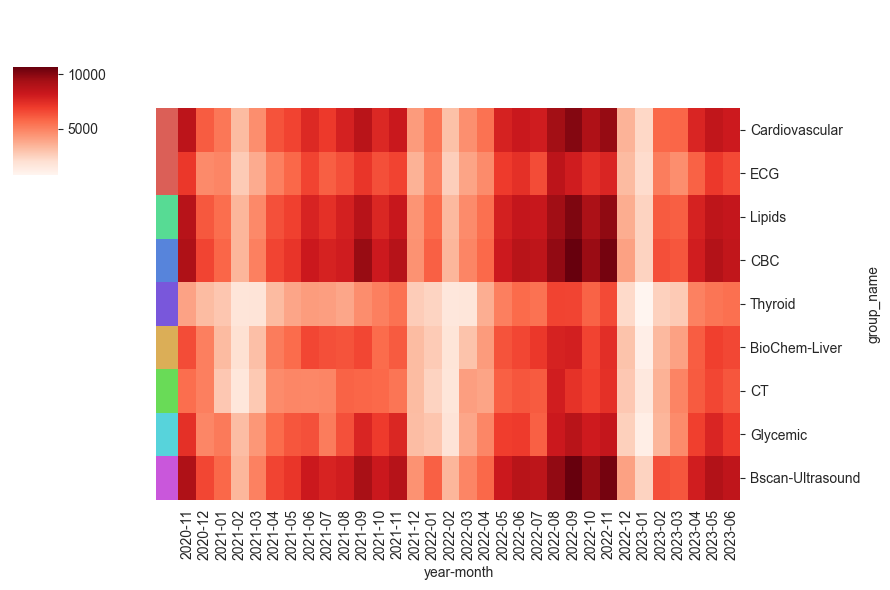

In [12]:
l_groups = [
        'Cardiovascular', 'ECG', 'Lipids',
        'CBC', 'Thyroid', 'BioChem-Liver',
        'CT', 'Glycemic', 'Bscan-Ultrasound',
]
df_cnt_mat = df_cnt.reset_index().groupby("group_name").agg(np.mean).loc[
    l_groups
]

fig = sns.clustermap(
            df_cnt_mat,
            cmap="Reds",
            row_cluster=False,
            row_colors=[ lut[x] for x in l_groups ],
            cbar_pos=(0.02, 0.7, 0.05, 0.18),
            col_cluster=False, figsize=(9,6),
)
fig.savefig(f"{workdir}/Figure1_E.pdf")

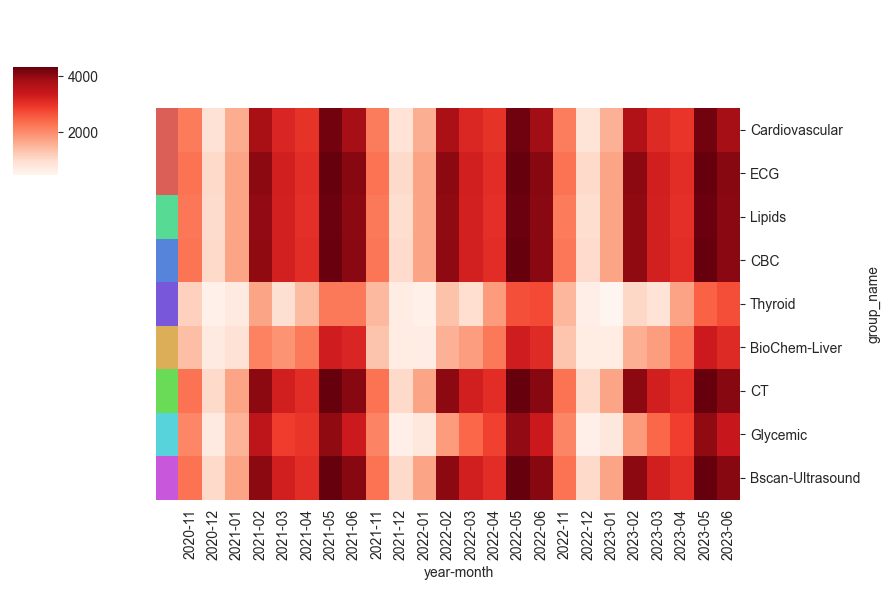

In [13]:
df_mat = df_table1plus_3p_revMM[l_high_lighted]
l_high_lighted_names = [ parse_dict_with_default(x, default_dict=rename_dict) for x in l_high_lighted ]
df_mat.columns = l_high_lighted_names
df_mat1 = (~pd.isna(df_mat))
df_mat1["year-month"] = df_table1plus_3p_revMM.apply(lambda x: "%04d-%02d" % (x["year"],x["month"]), axis=1)

df_cnt_melt = pd.melt(
            df_mat1, id_vars=["year-month"]
        )
df_cnt_melt["group_name"] = [ parse_dict_with_default(x, group_dict) for x in list(df_cnt_melt["variable"]) ]
df_cnt = df_cnt_melt.pivot_table(
            index=["variable", "group_name"], columns="year-month", aggfunc=sum, values="value"
).loc[l_high_lighted_names]

df_cnt_mat = df_cnt.reset_index().groupby("group_name").agg(np.mean).loc[
    l_groups
]
fig = sns.clustermap(
            df_cnt_mat,
            cmap="Reds",
            row_cluster=False,
            row_colors=[ lut[x] for x in l_groups ],
            cbar_pos=(0.02, 0.7, 0.05, 0.18),
            col_cluster=False, figsize=(9,6),
)
fig.savefig(f"{workdir}/FigureS1_B.pdf")

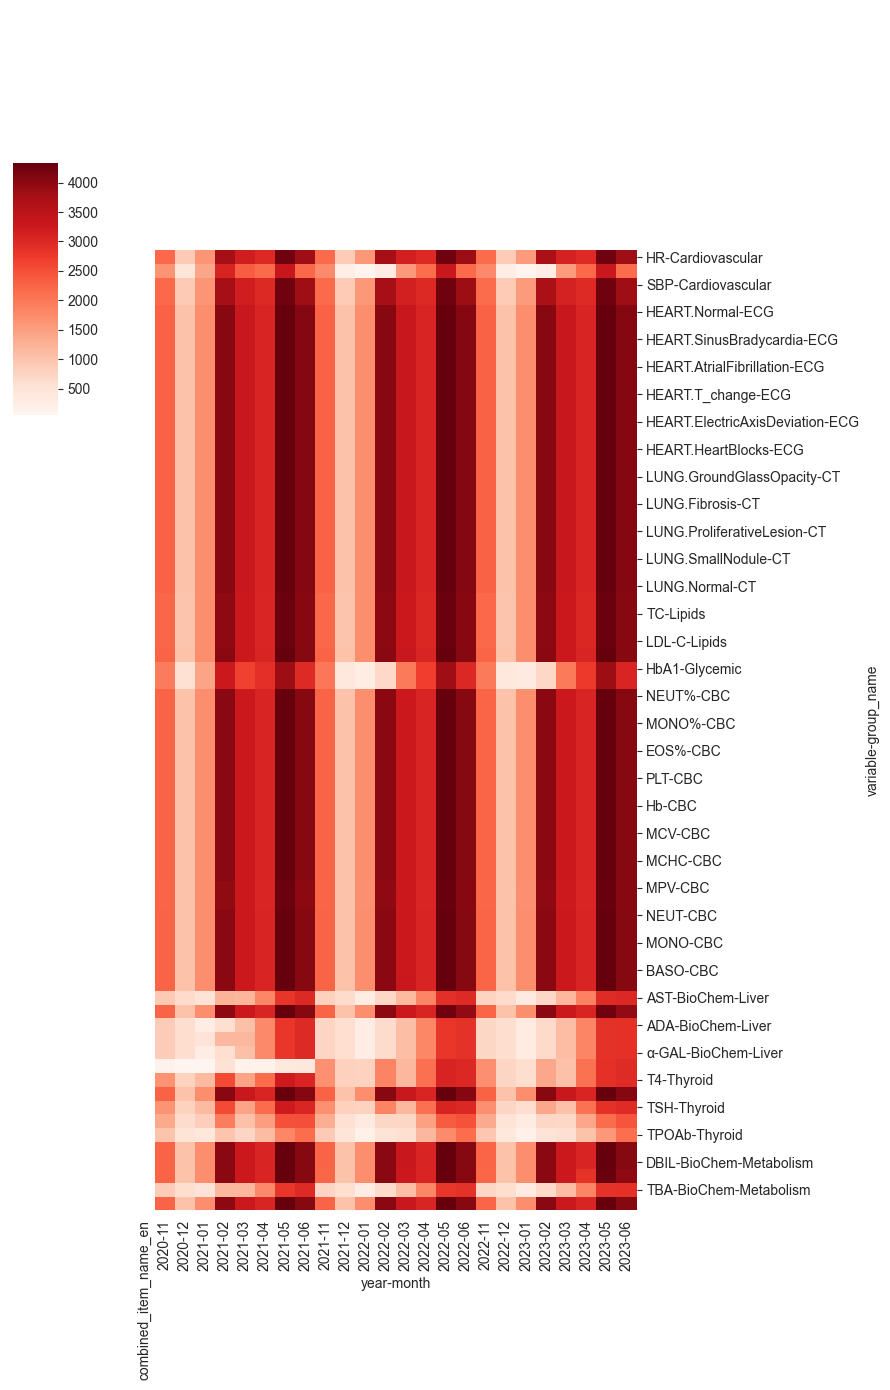

In [14]:
fig = sns.clustermap(df_cnt,
                    cmap="Reds",
                    row_cluster=False,
                    row_colors=row_colors,
                    cbar_pos=(0.02, 0.7, 0.05, 0.18),
                    col_cluster=False, figsize=(9,14),
)
fig.savefig(f"{workdir}/FigureS1_C.pdf")

## Interval of days for 3-periods examination people

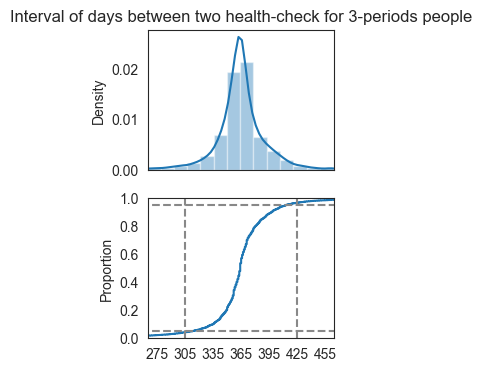

In [15]:
start_date0 = pd.Timestamp('2020-11-01')
df_months = df_table1plus[df_table1plus["sample_id"].isin(l_consecute_man3p)][["sample_id", "period"]]
df_months["ndays"] = df_table1plus[df_table1plus["sample_id"].isin(l_consecute_man3p)].apply(
                            lambda x: pd.Timestamp("%04d-%02d-%02d" % (x["year"],x["month"],x["day"]))-start_date0, axis=1
)
df_months_pvt = df_months.pivot_table(index="sample_id", columns="period", values="ndays", aggfunc=np.nanmedian)
df_months = (df_months_pvt["Test-2023"] - df_months_pvt["Control-2022"]).append(
    (df_months_pvt["Control-2022"] - df_months_pvt["Control-2021"])
) / np.timedelta64(1, 'D')
# ) / np.timedelta64(1, 'M') - 12
fig = plt.figure(figsize=(2.4,4))
ax1 = fig.add_subplot(2,1,1)
sns.distplot(df_months, ax=ax1)
ax1.set_xlim(-100+365,100+365)
ax1.set_xticks([])
ax1.set_title("Interval of days between two health-check for 3-periods people")

ax2 = fig.add_subplot(2,1,2)
sns.ecdfplot(df_months, ax=ax2)
ax2.set_xlim(-100+365,100+365)
ax2.set_xticks([365-90, 365-60, 365-30, 365, 365+30, 365+60, 365+90])
ax2.vlines(365-60, 0, 1, linestyles="dashed", color="#888888")
ax2.vlines(365+60, 0, 1, linestyles="dashed", color="#888888")
ax2.hlines(0.05, 365-120, 365+120, linestyles="dashed", color="#888888")
ax2.hlines(0.95, 365-120, 365+120, linestyles="dashed", color="#888888")


fig.savefig(f"{workdir}/Figure1_D.pdf")

## Scatter plot by month for important features

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.07it/s]


len                                                  mean  \
month            1     2     3     4     5     6    11    12           1   
period                                                                     
Control-2021  1721  4017  3278  3074  4321  4054  2276  1029    5.940110   
Control-2022  1715  4028  3278  3068  4326  4060  2261  1025    6.040090   
Test-2023     1716  4017  3268  3067  4325  4063  2244  1027    6.073325   
Control-2021  1708  3978  3251  3055  4285  4014  2258  1023   10.814666   
Control-2022  1699  3997  3253  3052  4307  4041  2246  1022   10.791642   
Test-2023     1701  3988  3244  3053  4308  4045  2234  1024   10.519518   
Control-2021  1721  4017  3278  3074  4321  4054  2276  1029   12.630796   
Control-2022  1715  4028  3278  3068  4326  4060  2261  1025   12.627668   
Test-2023     1716  4016  3268  3067  4325  4063  2244  1027   12.933596   
Control-2021  1721  4017  3278  3072  4319  4052  2276  1029  246.240170   
Control-2022  1715  4028  3278  3068  4326  4059  2260  1025  249.590379   
Test-2023     1715  4016  3267  3065  4323  4062  2244  1027  254.409913   
Control-2021  1721  4017  3278  3074  4321  4054  2276  1029  138.036316   
Control-2022  1715  4028  3278  3068  4326  4060  2261  1025  137.772886   
Test-2023     1716  4017  3268  3067  4325  4063  2244  1027  135.434441   
Control-2021  1613  3794  3180  3002  4253  3843  2201   907   85.448233   
Control-2022  1597  3768  3160  2996  4259  3869  2185   904   84.690044   
Test-2023     1556  3700  3123  2982  4250  3833  2164   889   86.496144   
Control-2021  1613  3794  3180  3002  4253  3843  2201   907  119.441414   
Control-2022  1597  3768  3160  2996  4259  3869  2185   904  119.494051   
Test-2023     1556  3698  3122  2982  4250  3833  2164   890  121.671272   
Control-2021  1613  3794  3180  3002  4253  3843  2201   907   71.090515   
Control-2022  1597  3768  3160  2996  4259  3869  2185   904   71.429869   
Test-2023     1556  3700  3123  2982  4250  3833  2164   890   73.777635   
Control-2021   839  1925  1039  1517  2491  2498  1364   643   13.363147   
Control-2022   338   735   724  1475  2351  2465  1302   573   13.405799   
Test-2023      304   723   711  1374  2161  2429  1350   504   13.655395   
Control-2021  1133  2555  1435  2169  3215  3061  1648   801  100.218323   
Control-2022   793  1845  1170  2121  3090  3019  1689   806   98.913607   
Test-2023      629  1375  1051  2090  2894  2974  1698   741  102.467814   
Control-2021  1720  4020  3278  3074  4322  4053  2276  1029   17.408915   
Control-2022  1716  4028  3280  3070  4327  4060  2261  1025   18.528263   
Test-2023     1715  4024  3272  3069  4326  4063  2244  1027   20.502915   

                          ...    func_q5    func_q95                          \
month                  2  ...         12           1           2           3   
period                    ...                                                  
Control-2021    6.023979  ...   2.900000    3.300000    3.210000    3.400000   
Control-2022    6.099943  ...   2.858480    3.205660    3.262565    3.341315   
Test-2023       6.202153  ...   2.424940    3.300000    3.430000    3.320365   
Control-2021   10.775318  ...   7.953300    8.800000    8.839075    8.700000   
Control-2022   10.723880  ...   8.153150    8.900000    8.800000    8.600000   
Test-2023      10.616199  ...   7.751150    8.200000    8.500000    8.200000   
Control-2021   12.659833  ...  10.854200   11.200000   11.200000   11.300000   
Control-2022   12.652147  ...  11.051200   11.200000   11.200000   11.400000   
Test-2023      12.964031  ...  11.002600   11.500000   11.500000   11.500000   
Control-2021  247.439383  ...  73.710000  126.680000  125.000000  125.000000   
Control-2022  251.283888  ...  77.728000  130.566000  126.000000  126.131500   
Test-2023     255.314741  ...  63.825000  128.000000  135.000000  126.027000   
Control-2021  138.903493  ...  81.056000   96.340000  100.000000  100.000000  

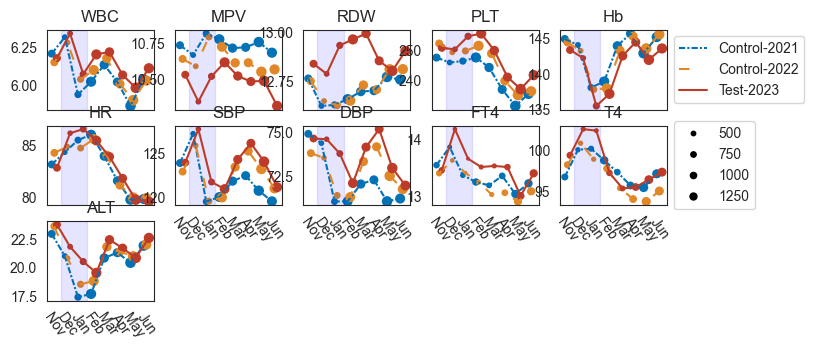

In [16]:
l_tags = [
        'v9045', 'v9065', 'v9063',  'v9064', "v9058", 
        'v000763','v000762', 'v002161', 'v9462', 'v0955',
        'v0017'
]
l_months2 = [11,12,1,2,3,4,5,6]
plt_scatter = Scatter(n_cols=5, figsize=(8,6), n_rows=5, rename_dict=rename_dict)

fig, df_res = plt_scatter.plot_scatter(df_table1plus_3p_revMM, l_tags, order=l_months2)
fig.savefig(f"{workdir}/Figure1_G.pdf")
df_res